In [441]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Imports

* Python libraries.
* Models for the NACA airfoil and the panel discretization. 

In [442]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from naca import NacaGenerator
from panel import Panel

# Vortex Panel Method

Define the NACA profile and the number of points. 

In [443]:
NACA = '0012'
NUM_POINTS_X = 100

Helper method to create the airfoil.

In [444]:
def generate_airfoil(NACA, NUM_POINTS_X):
    airfoil = NacaGenerator(naca=NACA)

    airfoil.generate_cosine_distribution(N=NUM_POINTS_X);
    airfoil.generate_naca();
    
    return airfoil

Generate the airfoil. 

Generating cosine distribution with 100 points ...


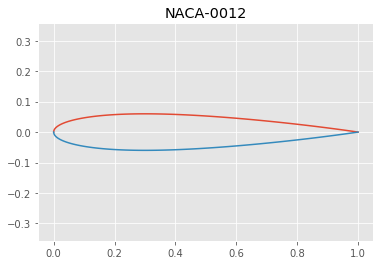

In [445]:
airfoil = generate_airfoil(NACA, NUM_POINTS_X=NUM_POINTS_X)

airfoil.plot()

Get the $(x,y)$ coordinates of the airfoil in the **clockwise** direction, starting by the trailing-edge. 

In [446]:
x, y = airfoil.clockwise_naca()

# Enforce actual zeros
x = np.where(np.isclose(x, 0), 0, x)
y = np.where(np.isclose(y, 0), 0, y)

In [447]:
N_b = len(x)

Build a list of panels in the **clockwise** direction. 

In [448]:
N_b

199

In [449]:
x_c   = np.zeros(N_b - 1)
y_c   = np.zeros(N_b - 1)
S     = np.zeros(N_b - 1)
theta = np.zeros(N_b - 1)
normals = []
lines = []

idx = 0
for xs, xe, ys, ye in zip(x, x[1:], y, y[1:]):
    
    # Control points
    x_c[idx] = (xs + xe) / 2.0
    y_c[idx] = (ys + ye) / 2.0
    
    # Length
    _S     = (xe - xs)**2.0 + (ye - ys)**2.0
    S[idx] = np.sqrt(_S) 
    
    # Angle
    theta[idx] = np.arctan2(ye - ys , 
                            xe - xs)
    
    #########
    # Vectors
    #########
    # Normal
    normal = np.array([-(ye-ys), (xe-xs)])
    normal = normal / np.linalg.norm(normal)
    
    normals.append(normal)
    
    # Line
    line = np.array([(xe-xs), (ye-ys)])
    line = line / np.linalg.norm(line)
    
    lines.append(line)
    
    # Update index counter
    idx += 1

normals = np.array(normals)
lines = np.array(lines)

Get the control points and the angles. 

In [450]:
Cn1 = np.zeros(shape = (N_b-1, N_b-1))
Cn2 = np.zeros(shape = (N_b-1, N_b-1))

Ct1 = np.zeros(shape = (N_b-1, N_b-1))
Ct2 = np.zeros(shape = (N_b-1, N_b-1))

for i in range(N_b-1):
    for j in range(N_b-1):
    
        if i == j:
            
            Cn1[i,j] = -1
            Cn2[i,j] =  1 
            
            Ct1[i,j] = 0.5 * np.pi
            Ct2[i,j] = 0.5 * np.pi
        
        else:
            
            A = - (x_c[i] - x[j])*(np.cos(theta[j])) - (y_c[i] - y[j])*(np.sin(theta[j]))
            B = (x_c[i] - x[j])**2.0 + (y_c[i] - y[j])**2.0
            C = np.sin(theta[i] - theta[j])
            D = np.cos(theta[i] - theta[j])
            E = (x_c[i] - x[j]) * np.sin(theta[j]) - (y_c[i] - y[j]) * np.cos(theta[j])
            F = np.log(1.0 + ((S[j])**2.0 + (2.0 * A * S[j])) / B)
            G = np.arctan2((E*S[j]) , (B + A * S[j]))
            P = ((x_c[i] - x[j]) * np.sin(theta[i] - 2.0 * theta[j])) + ((y_c[i] - y[j]) * np.cos(theta[i] - 2.0 * theta[j]))
            Q = ((x_c[i] - x[j]) * np.cos(theta[i] - 2.0 * theta[j])) - ((y_c[i] - y[j]) * np.sin(theta[i] - 2.0 * theta[j]))
            
            Cn2[i,j] = D + ((0.5 * Q * F) / S[j]) - ((A*C + D*E) * (G / S[j]))
            Cn1[i,j] = 0.5*D*F + C*G - Cn2[i,j]
            Ct2[i,j] = C + ((0.5 * P * F) / S[j]) + ((A*D - C*E) * (G / S[j]))
            Ct1[i,j] = 0.5*C*F - D*G - Ct2[i,j]

In [451]:
def summand(i, j, gamma):
    
    return Cn1[i,j] * gamma[j] + Cn2[i,j] * gamma[j+1]

In [452]:
def system_of_equations(gamma):
        
    # Prepare gammas
    result = np.zeros_like(gamma)
    
    # Matrix-product implementation
    for i in range(len(result)-1):
        for j in range(len(gamma)-1):
            
            result[i] += summand(i, j, gamma)
            
    # Compatibility condition at the end
    result[-1] = gamma[0] + gamma[-1]
    
    return result

## Airflow solution

So far, everything depends on the geometry. So now we are going to compute the RHS, which depends on the incidence angle. 

In [453]:
from scipy.sparse.linalg import LinearOperator
from scipy.sparse.linalg import gmres

An iterative linear operator will be used. This will not affect our solution, but will simplify the way we build the matrix. 

In [454]:
A = LinearOperator((N_b, N_b), matvec=system_of_equations)
A

<199x199 _CustomLinearOperator with dtype=float64>

In [467]:
ALPHA = -3.0
ALPHA = np.deg2rad(ALPHA)

# RHS
b = np.zeros(N_b)

for idx in range(len(b)-1):
    b[idx] = np.sin(theta[idx] - ALPHA)

# Kutta condition
b[-1] = 0.0

In [468]:
ITERATIONS_MAX     = 10000
ITERATIONS_RESTART = ITERATIONS_MAX

In [469]:
gammas, info = gmres(A, b, 
                     x0      = np.ones(N_b), 
                     restart = ITERATIONS_RESTART, 
                     maxiter = ITERATIONS_MAX, 
                     tol     = 1e-8,
                     atol    = 1e-8) 

In [470]:
info

0

In [471]:
def summand_tangential(i, j, gamma):
    
    return Ct1[i][j] * gamma[j] + Ct2[i][j] * gamma[j+1]

In [472]:
def compute_velocity(gamma):
    
    # Prepare gammas
    result = np.zeros(len(gamma)-1)
    
    # Matrix-product implementation
    for i in range(len(result)):
        for j in range(len(gamma)-1):
            
            result[i] += summand_tangential(i, j, gamma)
    
    return np.cos(theta - ALPHA) + result

In [473]:
def compute_pressure_distribution(gamma):
    
    velocity = compute_velocity(gamma)
    
    return 1.0 - np.power(velocity, 2.0)

In [474]:
def compute_lift(gamma):
    
    cp = compute_pressure_distribution(gamma)
    vec_j = np.array([0, 1])
     
    return np.sum(-cp * np.dot(normals, vec_j) * S)

In [475]:
compute_lift(gammas)

-0.3599597337903935

Text(0.5, 0, '$x$')

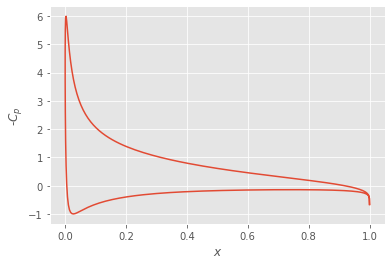

In [465]:
cp = compute_pressure_distribution(gammas)

plt.plot(x_c, -cp)
plt.ylabel('-$C_p$')
plt.xlabel('$x$')

Text(0.5, 0, '$x$')

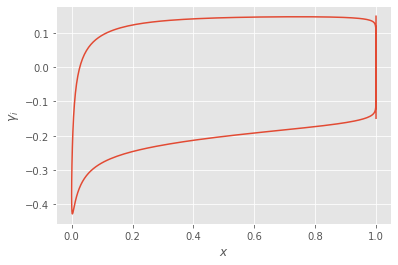

In [466]:
plt.plot(x, gammas)
plt.ylabel('$\gamma_i$')
plt.xlabel('$x$')

In [285]:
gammas

array([ 1.96820603e-02, -1.53301185e-01, -1.73773717e-01, -1.89084501e-01,
       -9.20152843e-13,  1.89084501e-01,  1.73773717e-01,  1.53301185e-01,
       -1.96820603e-02])